In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings

# Чтение и обработка данных

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.sample(5)

,Date,store,product,number_sold
47529,2014-02-20,1,4,732
123748,2015-10-31,3,7,400
165132,2012-02-22,5,0,770
66540,2012-03-11,2,0,752
111825,2010-03-09,3,4,343


In [ ]:
train_agg = train.groupby('Date', as_index=False)['number_sold'].sum()
test_agg = test.groupby('Date', as_index=False)['number_sold'].sum()

# Приводим колонку 'date' к типу datetime
train_agg['Date'] = pd.to_datetime(train_agg['Date'])
test_agg['Date'] = pd.to_datetime(test_agg['Date'])

train_agg.set_index('Date', inplace=True)
test_agg.set_index('Date', inplace=True)

In [ ]:
train_agg

,number_sold
Date,
2010-01-01,54870
2010-01-02,54960
2010-01-03,54863
2010-01-04,54926
2010-01-05,54634
...,...
2018-12-27,55448
2018-12-28,55416
2018-12-29,55473


# Анализ и визуализация

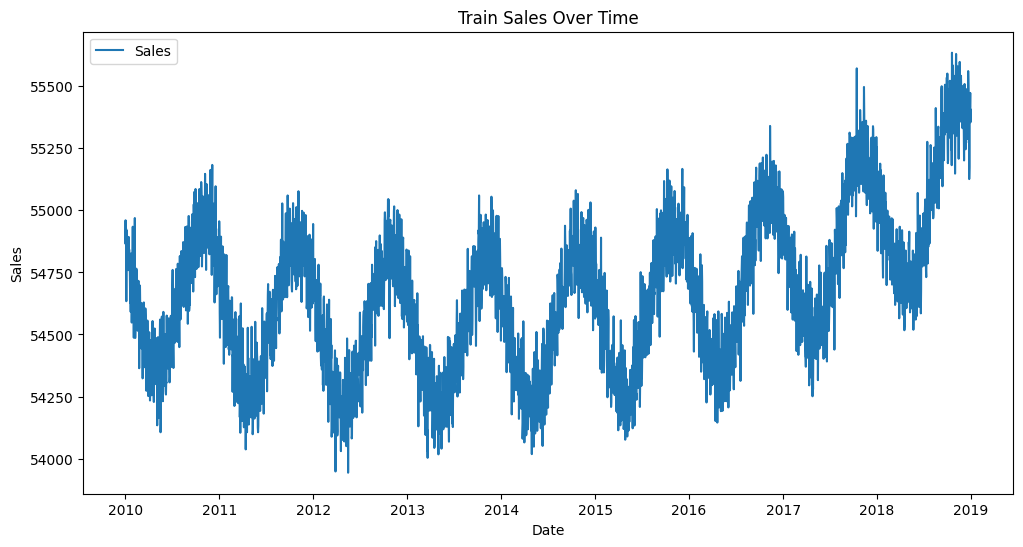

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Train Sales Over Time')
plt.plot(train_agg['number_sold'], label='Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Заметна явная сезонность в наших данных. Сезонная ARIMA должна хорошо справиться.

In [ ]:
# Проверим стационарность ряда с помощью теста Дики-Фуллера (чтобы определить параметр d у модели)
result = adfuller(train_agg['number_sold'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key,value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# Если ряд не стационарен (p-value > 0.05), можно взять разности
# Попробуем дифференцирование
train_diff = train_agg['number_sold'].diff().dropna()

# Проверим тест Дики-Фуллера на разностном ряду
result_diff = adfuller(train_diff)
print("Test on differenced series:")
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])

# Если ряд стационарен после дифференцирования, можно использовать ARIMA.
# Если есть сезонность, рассмотрим SARIMA. Сезонность по графику годовая.

ADF Statistic: -2.532370
p-value: 0.107796
Critical Values:
   1%, -3.4323593525669414
Critical Values:
   5%, -2.8624278120183573
Critical Values:
   10%, -2.567242601304915
Test on differenced series:
ADF Statistic: -7.113039
p-value: 0.000000


Первый тест показал отсутсвие стационарности, но после дифференцирования стационарность наблюдается. Это означает, что в SARIMA можно исопльзовать параметр диффееренцирования равным 1.

# Подбор параметров модели

Можно использовать автоматический подбор (например pmdarima), но здесь для примера вручную:
Предположу, что SARIMA(1,1,1)(1,1,1,365) подойдет неплохо т.к. мы заметили годовую сезонность.
Параметры p и q выбрали 1, чтобы не усложнять модель.

Однако, как можно заметить, по дням модель имеет слишком много компонент сезонности. В таком случае лучше агрегировать данные по месяцам. Все равно мы хотим предсказывать общий тренд, а по дням мы будем концентрироваться на колебаниях и в разы увеличим время обучения.

In [ ]:
train_monthly = pd.DataFrame(train_agg['number_sold'].resample('M').sum())
test_monthly = pd.DataFrame(test_agg['number_sold'].resample('M').sum())

<ipython-input-40-281508b6e558>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_monthly = pd.DataFrame(train_agg['number_sold'].resample('M').sum())
<ipython-input-40-281508b6e558>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_monthly = pd.DataFrame(test_agg['number_sold'].resample('M').sum())


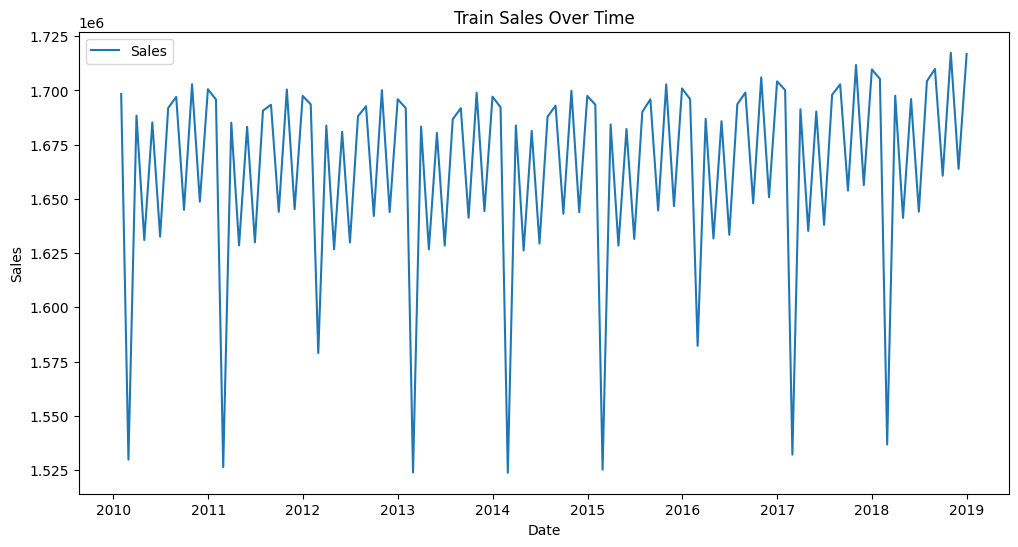

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Train Sales Over Time')
plt.plot(train_monthly['number_sold'], label='Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

При рассмотрении месяцев - сезонность также наблюдается. Попробуем работать с днями, но оставлять сезонность в 365 дней не самая лучшая идея т.к. такая модель будет очень долго обучаться. Если будет не очень, попробуем месяцы

In [ ]:
model = SARIMAX(train_monthly['number_sold'], order=(3,2,3), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          number_sold   No. Observations:                  108
Model:             SARIMAX(3, 2, 3)x(1, 1, [1], 12)   Log Likelihood                -844.871
Date:                              Tue, 17 Dec 2024   AIC                           1707.743
Time:                                      10:03:19   BIC                           1728.953
Sample:                                  01-31-2010   HQIC                          1716.234
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5061      1.406     -0.360      0.719      -3.261       2.249
ar.L2         -0.45

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Анализ остатков

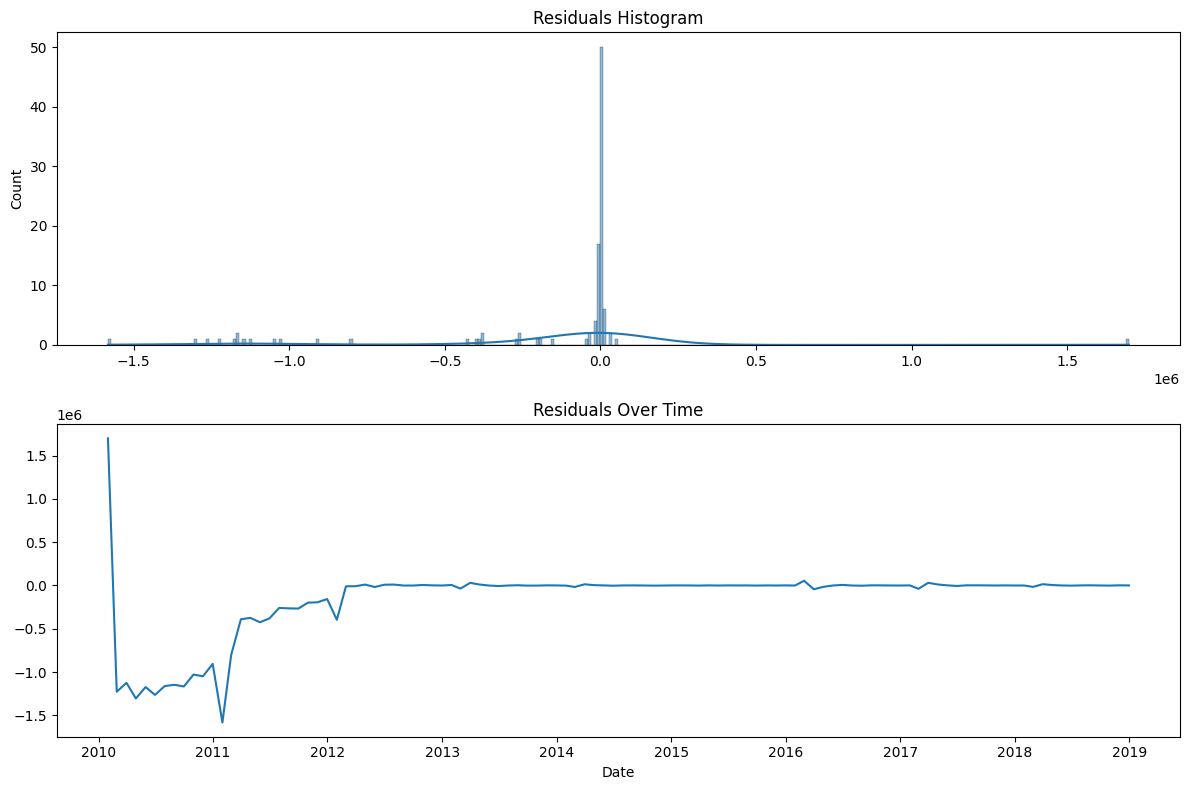

In [ ]:
residuals = results.resid
fig, ax = plt.subplots(2,1,figsize=(12,8))
sns.histplot(residuals, ax=ax[0], kde=True)

ax[0].set_title('Residuals Histogram')
sns.lineplot(x=residuals.index, y=residuals.values, ax=ax[1])
ax[1].set_title('Residuals Over Time')
plt.tight_layout()
plt.show()

In [ ]:
# Проверим коррелированность остатков с помощью ACF/PACF или Ljung-Box теста.
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_test)

       lb_stat     lb_pvalue
10  240.047302  6.696382e-46


# Прогнозирование

In [ ]:
# Предскажем на период тестовых данных
# Предполагаем, что test_agg идет сразу после train_agg
start = test_monthly.index[0]
end = test_monthly.index[-1]

pred = results.predict(start=start, end=end, dynamic=False)

# pred может понадобиться привести к нужному формату

# Метрики, оценка предсказаний

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAPE: 0.0007821783672615573
RMSE: 1478.9957603810024
R2: 0.999111468488349


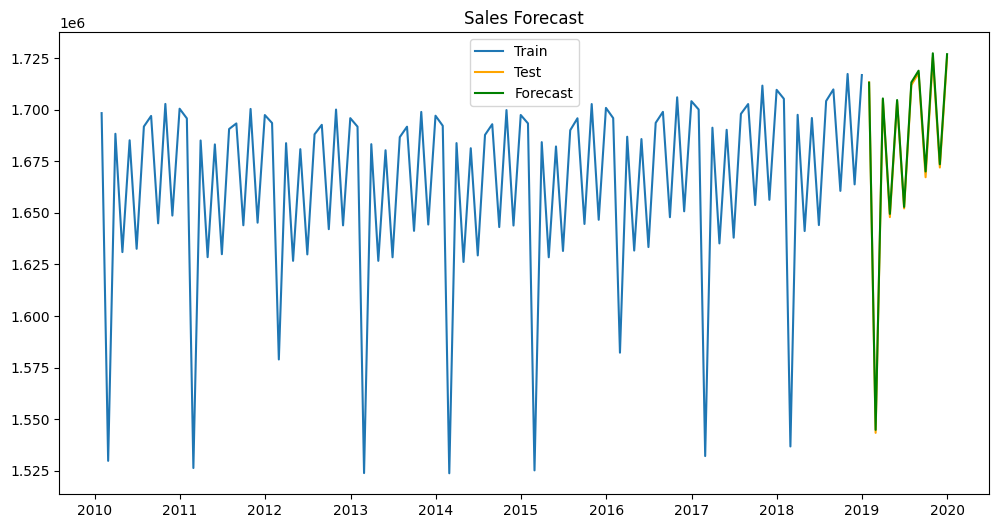

In [ ]:
# 6. Оценка качества предсказаний
y_true = test_monthly['number_sold']
y_pred = pred

mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

# Визуализация факта vs прогноз
plt.figure(figsize=(12,6))
plt.plot(train_monthly['number_sold'], label='Train')
plt.plot(test_monthly['number_sold'], label='Test', color='orange')
plt.plot(pred, label='Forecast', color='green')
plt.legend()
plt.title('Sales Forecast')
plt.show()

Выглядит очень неплохо. Приведем теперь данные к дневному формату, усредняя по дням внутри месяца. Я добавил комментарии, чтобы было понятнее.

<ipython-input-58-820e2eb053d4>:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  re_agg = daily_pred.resample('M').sum()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


            Monthly Forecast  Re-aggregated from Daily
2019-01-31      1.713157e+06              1.713157e+06
2019-02-28      1.544776e+06              1.544776e+06
2019-03-31      1.705526e+06              1.705526e+06
2019-04-30      1.649527e+06              1.649527e+06
2019-05-31      1.704758e+06              1.704758e+06
2019-06-30      1.652932e+06              1.652932e+06
2019-07-31      1.713319e+06              1.713319e+06
2019-08-31      1.718983e+06              1.718983e+06
2019-09-30      1.670103e+06              1.670103e+06
2019-10-31      1.727430e+06              1.727430e+06
2019-11-30      1.673605e+06              1.673605e+06
2019-12-31      1.726992e+06              1.726992e+06
Daily MAPE: 0.0018388910539045191
Daily RMSE: 126.81299470966992
Daily R2: 0.8279322425521045


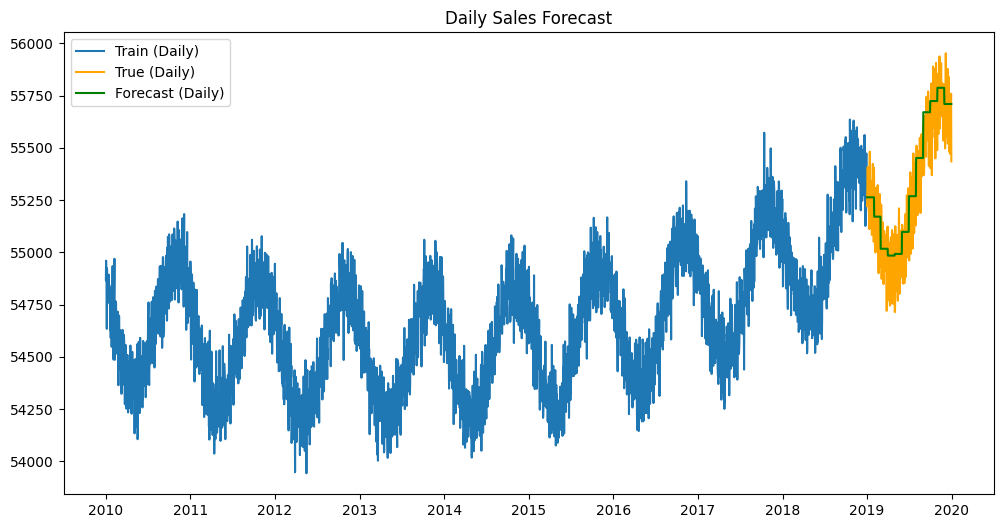

In [ ]:
import pandas as pd
import numpy as np

# Создадим DataFrame с ежедневными датами тестовой выборки:
test_daily_dates = test_agg.index

# Создадим пустой Series для ежедневных предсказаний
daily_pred = pd.Series(index=test_daily_dates, dtype=float)

# Для каждого месяца возьмём предсказанное месячное значение и разделим на число дней в данном месяце
for month_end in pred.index:
    # Найдём все дни, попадающие в этот месяц
    # Предполагается, что индекс month_end - это конец соответствующего месяца
    month_str = month_end.strftime('%Y-%m')

    # Фильтруем по год-месяц
    mask = test_daily_dates.strftime('%Y-%m') == month_str
    days_in_month = sum(mask)

    if days_in_month > 0:
        monthly_forecast = pred.loc[month_end]
        daily_value = monthly_forecast / days_in_month
        daily_pred.loc[mask] = daily_value

# Теперь daily_pred содержит ежедневный прогноз, который агрегируется в месячный при суммировании.
# Проверим агрегирование, чтобы убедиться, что всё совпадает:
re_agg = daily_pred.resample('M').sum()

# re_agg должно быть очень близко к pred (чисто из графика выше) (возможно, разница в 1 день, если индексы месяцев отличаются)
# Можно проверить так:
print(pd.concat([pred.rename('Monthly Forecast'), re_agg.rename('Re-aggregated from Daily')], axis=1))

# При необходимости можно пересчитать метрики качества теперь в ежедневном разрезе:
y_true_daily = test_agg['number_sold']
y_pred_daily = daily_pred

mape_daily = mean_absolute_percentage_error(y_true_daily, y_pred_daily)
rmse_daily = mean_squared_error(y_true_daily, y_pred_daily, squared=False)
r2_daily = r2_score(y_true_daily, y_pred_daily)

print("Daily MAPE:", mape_daily)
print("Daily RMSE:", rmse_daily)
print("Daily R2:", r2_daily)

# Визуализация факта vs ежедневный прогноз
plt.figure(figsize=(12,6))
plt.plot(train_agg['number_sold'], label='Train (Daily)')
plt.plot(y_true_daily, label='True (Daily)', color='orange')
plt.plot(y_pred_daily, label='Forecast (Daily)', color='green')
plt.title('Daily Sales Forecast')
plt.legend()
plt.show()

На основе метрик можно сделать вывод, что результаты хорошие.